<a href="https://colab.research.google.com/github/MaximeSzymanski/StocksClusteringVAE/blob/main/VAE_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup


In [56]:
!pip install yfinance
!pip install BeautifulSoup
!pip install requests


  Using cached BeautifulSoup-3.2.2.tar.gz (32 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
df = pd.DataFrame()
# request this url https://en.wikipedia.org/wiki/List_of_S%26P_600_companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_600_companies'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
# get the table by the id constituents
table = soup.find('table', {'id': 'constituents'})
ticker_list = []
# iterate over the tr balise in the table
for tr in table.find_all('tr'):
    # get the first td balise in the tr balise
    td = tr.findAll('td')
    # if the td balise is not empty
    if td is not None and len(td) > 1:
        # get the first a balise in the td balise

        a = td[0].find('a')
        # if the a balise is not empty
        if a is not None:
            # get the text of the a balise
            ticker = a.text
            # add the ticker to the list
            print(f"ticker : {ticker}")
            ticker_list.append(ticker)

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Define a list of stock symbols
stock_symbols = ticker_list[:100]
print(f"stock_symbols : {stock_symbols}")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
# Define the date range for the past 4 years
start_date = '2019-11-08'
end_date = '2023-11-08'

# Initialize an empty list to store normalized values
normalized_values_list = []
stocks_kept = []
iterator = 0
# Loop through each stock symbol
for symbol in stock_symbols:
    # Download historical stock data using yfinance
    stock_data = yf.download(symbol, start=start_date, end=end_date)

    # Extract the 'Close' column
    close_values = stock_data['Close'].values

    # Normalize the data between -1 and 1
    normalized_values = 2 * (close_values - np.min(close_values)) / np.ptp(close_values) - 1

    # Remove the last 6 values
    normalized_values = normalized_values[:-6]
    if len(normalized_values) == 1000:
      # Append normalized values to the list
      normalized_values_list.append(normalized_values)
      stocks_kept.append(symbol)
    print(f"stocks {iterator}/{len(stock_symbols)}")
    iterator += 1
# Plot the normalized data
plt.figure(figsize=(10, 6))

# Loop through the list of normalized values and plot each stock
for i in range(len(stock_symbols)):
    plt.plot(normalized_values_list[i], label=stock_symbols[i])

plt.legend(stock_symbols)
plt.title('Normalized Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()


In [ ]:
# Check that the length of each normalized series is divisible by sub_series_length
sub_series_length = 100
stock_symbols = stocks_kept

number_of_sub_series = len(normalized_values_list[0]) // sub_series_length

for i in range(len(stock_symbols)):
    assert len(normalized_values_list[i]) % sub_series_length == 0

# Create sub-series for each stock
sub_series_list = [normalized_values.reshape((-1, sub_series_length)) for normalized_values in normalized_values_list]

# convert the list to numpy array
stocks_np_array = np.zeros((len(stock_symbols), sub_series_list[0].shape[0], sub_series_list[0].shape[1]))
for i in range(len(stock_symbols)):
    stocks_np_array[i] = sub_series_list[i]

# Print the shape of each sub-series
for i in range(len(stock_symbols)):
    print(f"sub_series shape for {stock_symbols[i]}: {sub_series_list[i].shape}")

# Choose the number of sub-series based on the first stock
number_of_sub_series = sub_series_list[0].shape[0]
print(f"Number of sub-series: {number_of_sub_series}")
print(f"sub series list shape : {stocks_np_array.shape}")

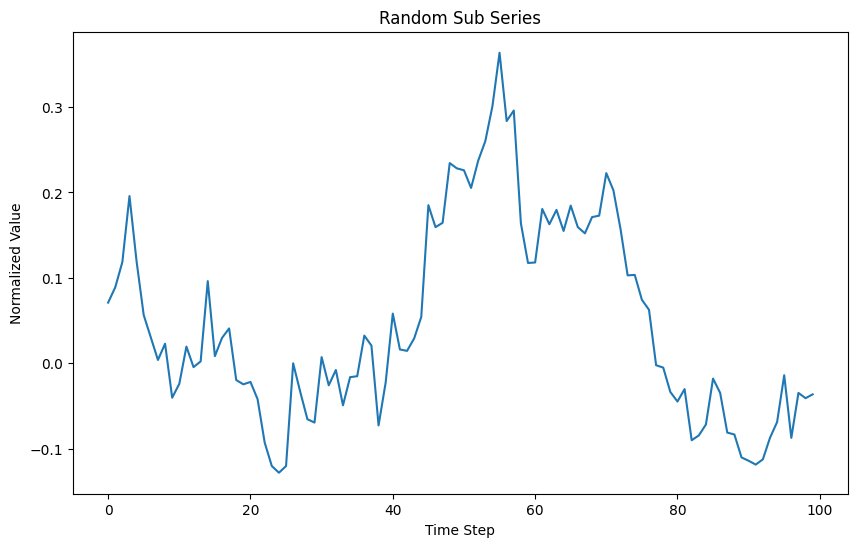

In [60]:
# print a random sub series
number_of_stocks = len(stock_symbols)
random_index_stocks = np.random.randint(0, number_of_stocks)
random_index_sub_series = np.random.randint(0, number_of_sub_series)
plt.figure(figsize=(10, 6))
plt.plot(stocks_np_array[random_index_stocks][random_index_sub_series])
plt.title('Random Sub Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()


In [ ]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
class SamplingLayerVAE(nn.Module):
  def __init__(self):
    super(SamplingLayerVAE, self).__init__()

  def forward(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64,num_layers=3,bidirectional=False,
               transfromer_hidden_size_attention = 128,num_heads=8,sub_seq_len=20,
               latent_dim=64):
    super(Encoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    print(f"hidden_dim: {self.hidden_dim}")
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.mu = nn.Linear(self.sub_seq_len*self.embedding_dim, latent_dim)
    self.log_var = nn.Linear(self.sub_seq_len*self.embedding_dim, latent_dim)
    self.sampling_layer = SamplingLayerVAE()
    self.rnn1 = nn.LSTM(
          input_size=embedding_dim,
          hidden_size=self.hidden_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )


    multiple_bi = 2 if bidirectional else 1

    self.rnn2 = nn.LSTM(
          input_size=multiple_bi * self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=self.num_layers,
          batch_first=True
    )
    #self.positional_encoding = PositionalEncoding(embedding_dim)
    self.embedding_layer = nn.Linear(n_features, embedding_dim)
    print(f"embedding_dim: {embedding_dim}")
    self.transformer_1 = CompressWithAttentionResidual(input_size=embedding_dim,output_size=embedding_dim,
                                             hidden_size_attention=embedding_dim,
                                             group_size=self.number_of_sub_seq)


  def forward(self, x):
    batch_size, seq_len, n_features = x.size()
    original_x = x
    #x = x.reshape((batch_size * seq_len, n_features))
    x = self.embedding_layer(x)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    x = self.transformer_1(x)
    x = x.reshape((batch_size, self.sub_seq_len*self.embedding_dim))
    mu = self.mu(x)
    log_var = self.log_var(x)
    z = self.sampling_layer(mu, log_var)

    return z, mu, log_var, original_x



class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1,num_layers=3,bidirectional=False,
               sub_seq_len=20,latent_dim=64):
    super(Decoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.output_embeding = OutputEmbedding(input_dim=self.hidden_dim,seq_len=self.seq_len,output_dim=1)
    self.rnn1 = nn.LSTM(
          input_size=latent_dim,
          hidden_size=input_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )

    multiple_bi = 2 if bidirectional else 1
    self.rnn2 = nn.LSTM(
      input_size=input_dim * multiple_bi,
      hidden_size=self.hidden_dim,
      num_layers=self.num_layers,
      batch_first=True
    )
  def forward(self, x):


    batch_size = x.size(0)
    # x is shape (batch_size, 1, n_features)
    # repeat the last dimension to have (batch_size, seq_len, n_features)
    x = x.unsqueeze(1).repeat(1, self.seq_len, 1)


    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((batch_size,self.seq_len, self.hidden_dim))
    x = self.output_embeding(x)

    # keep only the last layer


    return x

class CompressWithAttentionResidual(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_attention, group_size):
        super(CompressWithAttentionResidual, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size_attention
        self.group_size = group_size

        # Linear projections for attention
        self.Q_linear = nn.Linear(self.input_size, self.hidden_size)
        self.K_linear = nn.Linear(self.input_size, self.hidden_size)
        self.V_linear = nn.Linear(self.input_size, self.hidden_size)

        # Final linear transformations
        self.attention_output_linear = nn.Linear(self.hidden_size, self.hidden_size)
        self.output_linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        # x is shape (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = x.size()
        # Reshape input into groups of size self.group_size
        x = x.view(batch_size, -1, self.group_size, n_features)
        group_len = x.size(1)

        # Linear projections for attention
        Q = self.Q_linear(x)
        K = self.K_linear(x)
        V = self.V_linear(x)

        # Compute attention weights
        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        attention_weights = F.softmax(attention_weights, dim=-1)

        # Apply attention weights to values
        attended_values = torch.matmul(attention_weights, V)

        # Sum along the group dimension
        attended_values = attended_values.sum(dim=2)

        # Apply final linear transformations
        attention_output = self.attention_output_linear(attended_values)
        # Add residual connection
        out = attention_output

        # Final linear transformation
        out = self.output_linear(out)

        # RElu
        out = F.relu(out)

        return out

class InputEmbedding(nn.Module):
    def __init__(self,seq_len, input_dim=1,output_dim=64):
        super(InputEmbedding, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Linear(self.input_dim, self.output_dim)
    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        x = x.reshape((batch_size * seq_len, n_features))
        x = self.embedding(x)
        x = x.reshape((batch_size, seq_len, self.output_dim))
        return x

class OutputEmbedding(nn.Module):
    def __init__(self,seq_len, input_dim=64,output_dim=1):
        super(OutputEmbedding, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Linear(self.input_dim, self.output_dim)
    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        x = x.reshape((batch_size * seq_len, n_features))
        x = self.embedding(x)
        x = x.reshape((batch_size, seq_len, self.output_dim))
        return x
"""class PositionalEncoding(nn.Module):
    # write positional encoding for time series data
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        self.max_len = max_len
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.pe = torch.zeros(self.max_len, self.d_model).to(self.device)
        position = torch.arange(0, self.max_len, dtype=torch.float).unsqueeze(1).to(self.device)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model)).to(self.device)
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0).transpose(0, 1)
    def forward(self, x):
        x = x.permute(1, 0, 2)
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x).permute(1, 0, 2)"""




In [62]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=128,sub_seq_len=10,latent_dim=2):
    super(RecurrentAutoencoder, self).__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.encoder = Encoder(seq_len, n_features, embedding_dim,bidirectional=True,num_layers=1,
        sub_seq_len=sub_seq_len,latent_dim=latent_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features,bidirectional=True,num_layers=1,
        sub_seq_len=sub_seq_len,latent_dim=latent_dim).to(device)
  def forward(self, x):
    z, mu, sigma, original_x = self.encoder(x)
    x = self.decoder(z)
    x = nn.Tanh()(x)
    return x, original_x, mu, sigma

In [63]:
print(f"sub_series_length : {sub_series_length}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 32
model = RecurrentAutoencoder(sub_series_length, 1, 128,sub_seq_len=50,latent_dim=latent_dim).to(device)
print(f"model : {model}")

sub_series_length : 100
hidden_dim: 256
embedding_dim: 128
model : RecurrentAutoencoder(
  (encoder): Encoder(
    (mu): Linear(in_features=6400, out_features=32, bias=True)
    (log_var): Linear(in_features=6400, out_features=32, bias=True)
    (sampling_layer): SamplingLayerVAE()
    (rnn1): LSTM(128, 256, batch_first=True, bidirectional=True)
    (rnn2): LSTM(512, 128, batch_first=True)
    (embedding_layer): Linear(in_features=1, out_features=128, bias=True)
    (transformer_1): CompressWithAttentionResidual(
      (Q_linear): Linear(in_features=128, out_features=128, bias=True)
      (K_linear): Linear(in_features=128, out_features=128, bias=True)
      (V_linear): Linear(in_features=128, out_features=128, bias=True)
      (attention_output_linear): Linear(in_features=128, out_features=128, bias=True)
      (output_linear): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (output_embeding): OutputEmbedding(
      (embedding): Linear(in_featu

In [64]:
def KL_loss(mu, sigma):
    return -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

def reconstruction_loss(x, y):

    return nn.MSELoss(reduction='sum')(x,y)

def loss_function(x, original_x, mu, sigma,k1=1,k2=1e-2):
    return k1 *reconstruction_loss(original_x, x) + k2 * KL_loss(mu, sigma)


In [ ]:
# Convert the numpy array to a PyTorch tensor
# The shape is : (number_of_stocks, number_of_sub_series, sub_series_length, features)
# We need to reshape it to (number_of_stocks * number_of_sub_series, sub_series_length, features)
number_of_stocks = len(stocks_kept)


stocks_np_array = stocks_np_array.reshape((number_of_stocks*number_of_sub_series, sub_series_length, 1))
signal_to_tensor = torch.from_numpy(stocks_np_array).float().to(device)
print(f"Signal to tensor: {signal_to_tensor.shape}")

# Forward pass through the model
x, original_x, mu, sigma = model(signal_to_tensor)

# Reconstruct the good output shape
x = x.reshape((number_of_stocks, number_of_sub_series, sub_series_length, 1))
print(f"Input shape: {signal_to_tensor.shape}")
print(f"Output shape: {x.shape}")

In [ ]:
# Plot the reconstruction
# Plot 10 random stocks
number_of_stocks_to_plot = 5
random_stocks = np.random.randint(0, number_of_stocks, number_of_stocks_to_plot)
print(f"random stocks : {random_stocks}")
# Plot 10 random sub-series
random_sub_series = np.random.randint(0, number_of_sub_series, number_of_stocks_to_plot)
print(f"random sub series : {random_sub_series}")
# Plot the original and reconstructed signals
for i in range(number_of_stocks_to_plot):
    plt.plot(original_x[random_stocks[i]][random_sub_series[i]].cpu().detach().numpy(), label='Original signal')
    plt.plot(x[random_stocks[i]][random_sub_series[i]].cpu().detach().numpy(), label='Reconstructed signal')
plt.legend()
plt.show()



In [ ]:
# try a simple overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
#loss_fn = nn.L1Loss(reduction='sum')

for epoch in range(2000):
    optimizer.zero_grad()
    x, original_x, mu, sigma = model(signal_to_tensor)

    loss = loss_function(x, original_x, mu, sigma)
    loss.backward()
    # visualize the gradients of the last lstm layer

    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item()}')

x shape : (970, 100, 1)
number_of_stocks : 97
number_of_sub_series : 10
sub_series_length : 100
stocks_np_array_reshaped shape : (97, 10, 100)


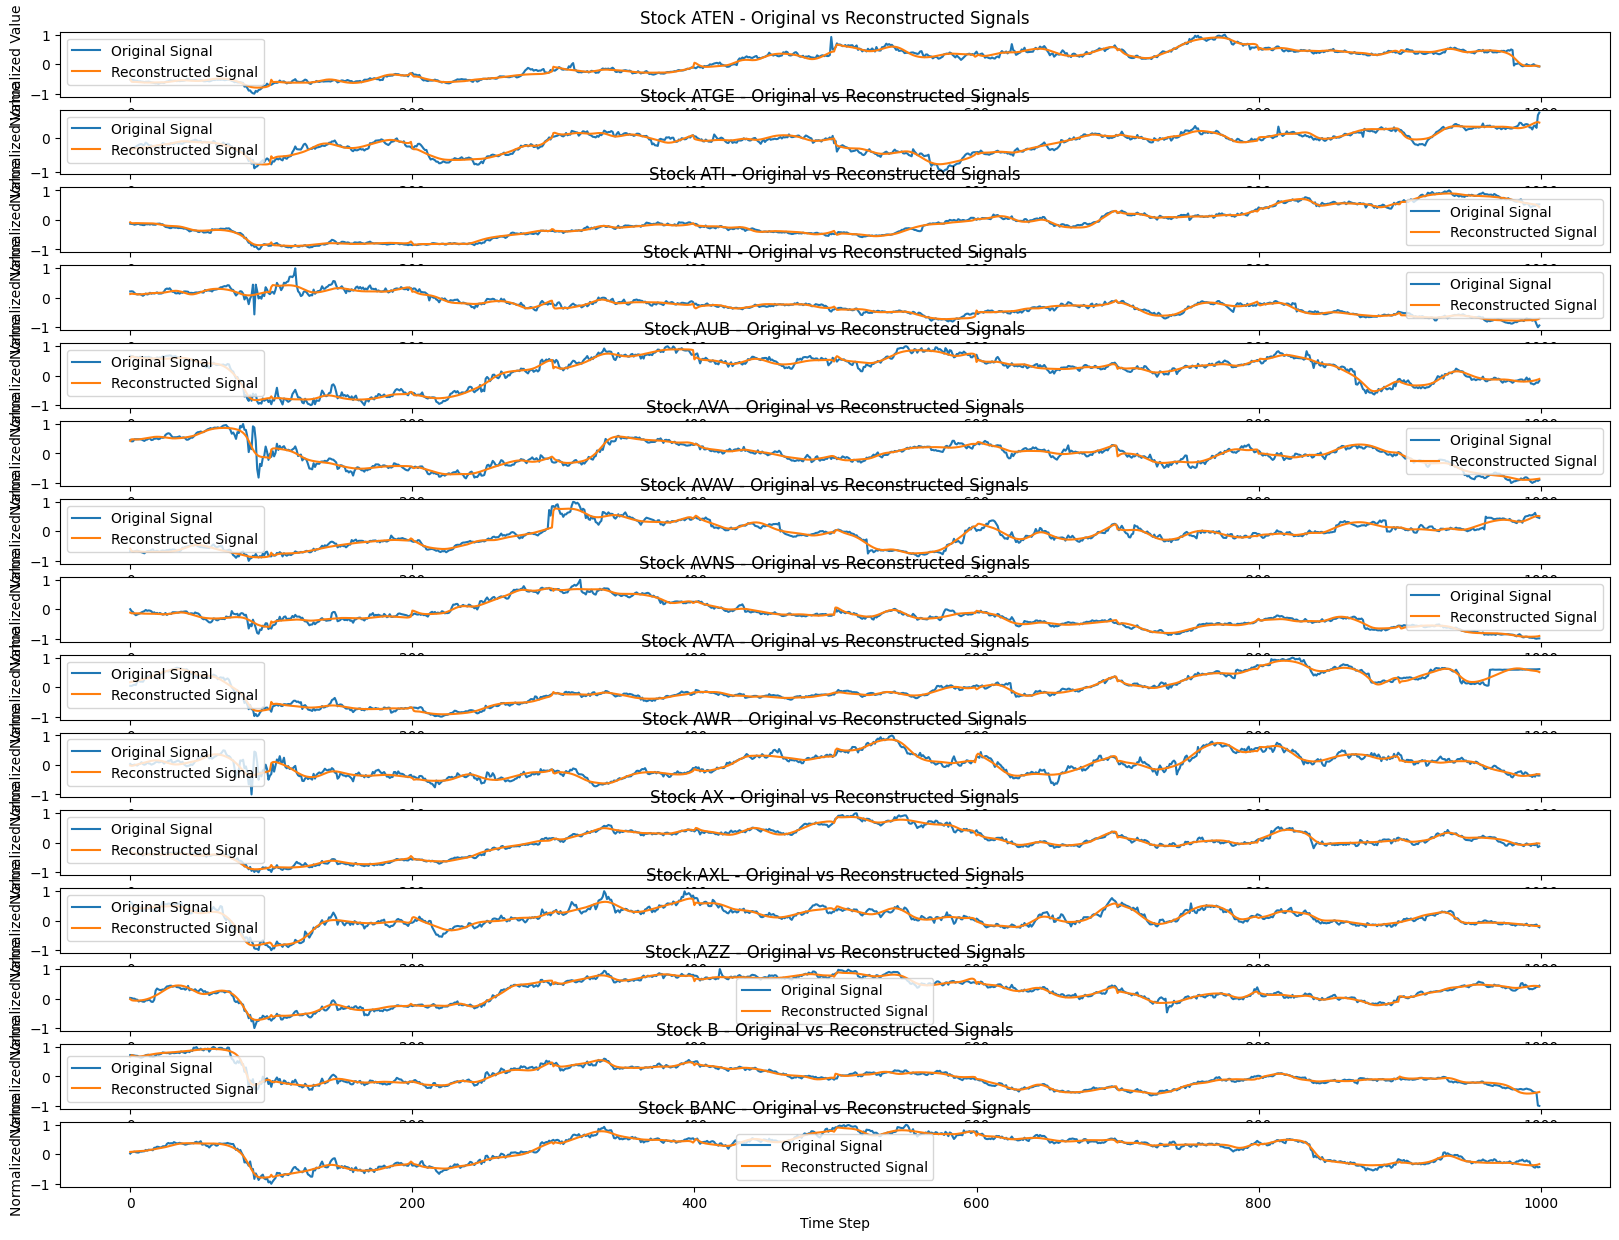

In [119]:
import matplotlib.pyplot as plt
with torch.no_grad():
    x, original_x, mu, sigma = model(signal_to_tensor)
    x = x.cpu().detach().numpy()
print(f"x shape : {x.shape}")
# Plot the reconstruction of all signals

stocks_to_plot = 15
# Reshape the data
print(f"number_of_stocks : {number_of_stocks}")
print(f"number_of_sub_series : {number_of_sub_series}")
print(f"sub_series_length : {sub_series_length}")
stocks_np_array_reshaped = stocks_np_array.reshape((number_of_stocks, number_of_sub_series, sub_series_length))
reconstructed_signals_reshaped = x.reshape((number_of_stocks, number_of_sub_series, sub_series_length, 1))
print(f"stocks_np_array_reshaped shape : {stocks_np_array_reshaped.shape}")
# Plot each stock in separate subplots
plt.figure(figsize=(20, 15))

for i in range(stocks_to_plot):
    plt.subplot(stocks_to_plot, 1, i + 1)
    plt.plot(stocks_np_array_reshaped[i+50].reshape((-1, 1)), label='Original Signal')
    plt.plot(reconstructed_signals_reshaped[i+50].reshape((-1, 1)), label='Reconstructed Signal')
    plt.title(f'Stock {stocks_kept[i+50]} - Original vs Reconstructed Signals')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.legend()


plt.show()


signals_latent shape : (970, 32)
latent_space_np_array shape : (97, 10, 2)


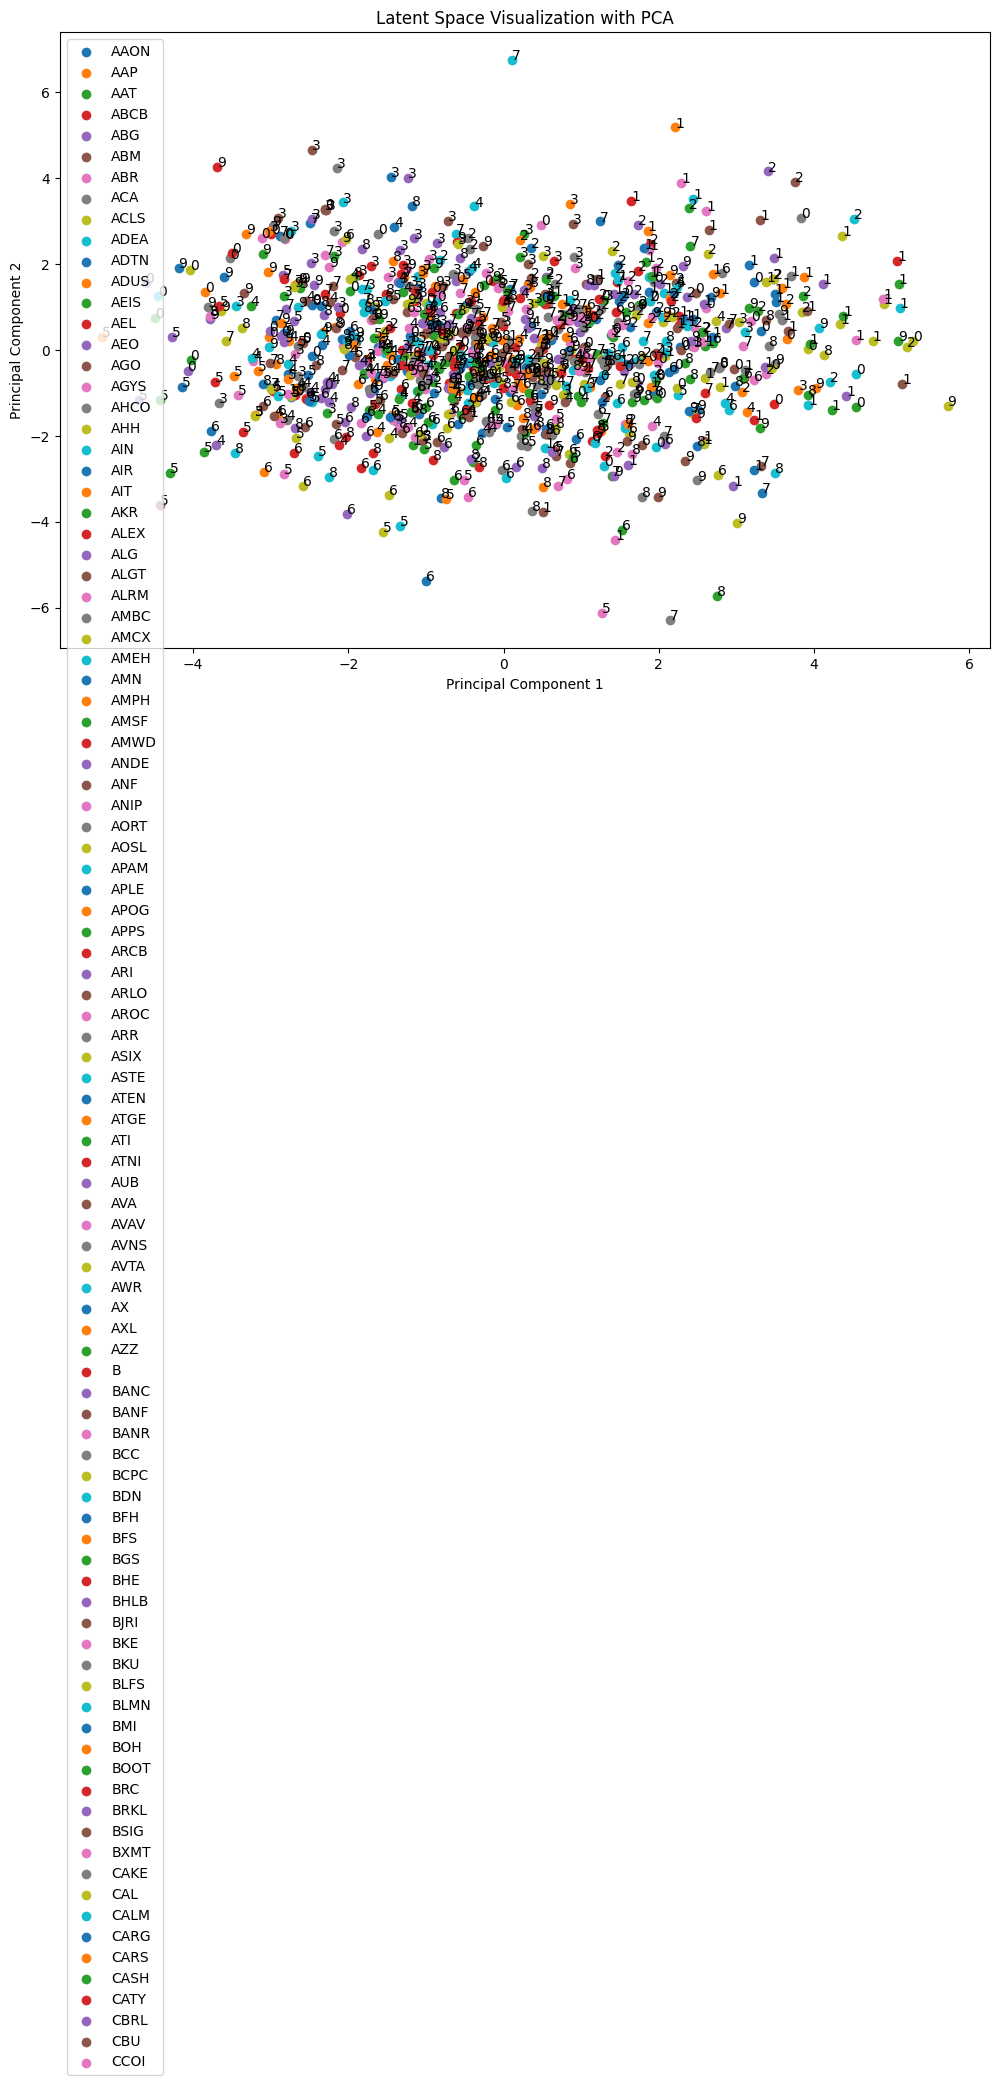

In [120]:
# Apply PCA to the latent space

from sklearn.decomposition import PCA
# Set seeds for reproducibility


with torch.no_grad():
    signals_latent,_,_,_ = model.encoder(signal_to_tensor)
    signals_latent = signals_latent.squeeze().cpu().detach().numpy()
print(f"signals_latent shape : {signals_latent.shape}")
pca = PCA(n_components=2)
latent_space = pca.fit_transform(signals_latent)
# Reshape the latent space for each stock

latent_space_np_array = np.array(latent_space).reshape((number_of_stocks, number_of_sub_series, 2))
print(f"latent_space_np_array shape : {latent_space_np_array.shape}")
# Plot the latent space for each stock
plt.figure(figsize=(12, 8))

for i, latent_space_stock in enumerate(latent_space_np_array):
    plt.scatter(latent_space_stock[:, 0], latent_space_stock[:, 1], label=f'{stock_symbols[i]}')

    # Annotate each point with its index
    for j in range(number_of_sub_series):
        plt.annotate(str(j), (latent_space_stock[j, 0], latent_space_stock[j, 1]))

plt.legend()
plt.title('Latent Space Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

torch.Size([970, 100, 1])
(970, 32)
signals_latent shape : (97, 32)
(97, 2)
latent_space_np_array shape : (97, 2)


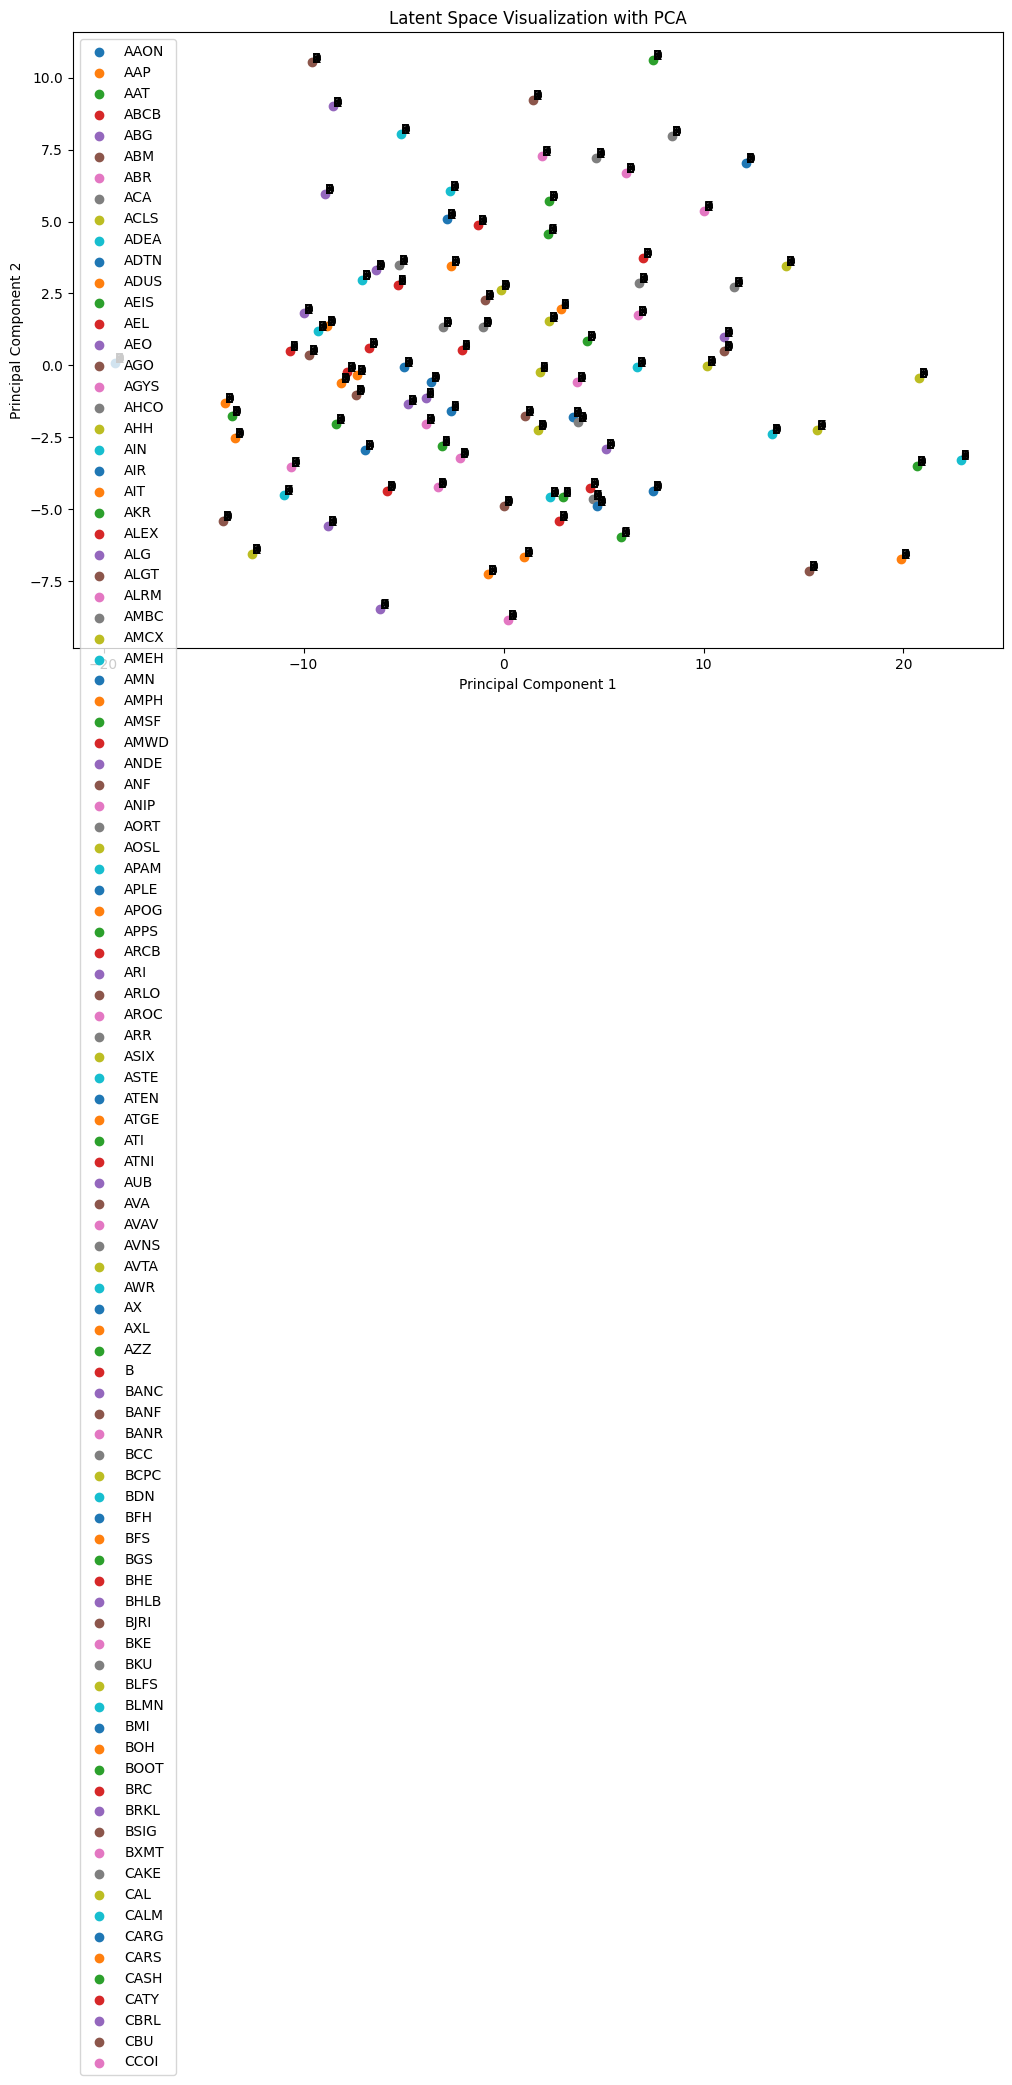

In [121]:
# Apply PCA to the latent space

from sklearn.decomposition import PCA
# Set seeds for reproducibility

print(signal_to_tensor.shape)
with torch.no_grad():
    signals_latent,_,_,_ = model.encoder(signal_to_tensor)
    signals_latent = signals_latent.squeeze().cpu().detach().numpy()
    print(signals_latent.shape)
signals_latent_sumed = signals_latent.reshape(number_of_stocks,number_of_sub_series,latent_dim )

signals_latent_sumed = np.sum(signals_latent_sumed, axis=(1))

print(f"signals_latent shape : {signals_latent_sumed.shape}")
pca = PCA(n_components=2)
latent_space = pca.fit_transform(signals_latent_sumed)
# Reshape the latent space for each stock
print(latent_space.shape)
latent_space_np_array = np.array(latent_space).reshape((number_of_stocks, 2))
print(f"latent_space_np_array shape : {latent_space_np_array.shape}")
# Plot the latent space for each stock
plt.figure(figsize=(12, 8))

for i, latent_space_stock in enumerate(latent_space_np_array):
    plt.scatter(latent_space_stock[0], latent_space_stock[1], label=f'{stock_symbols[i]}')

    # Annotate each point with its index
    for j in range(number_of_sub_series):
        plt.annotate(str(j), (latent_space_stock[0], latent_space_stock[1]))

plt.legend()
plt.title('Latent Space Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

latent_signal_np_array shape : (970, 32)
number_of_points : 10
signal_1 shape : (10, 32)
signal_2 shape : (10, 32)


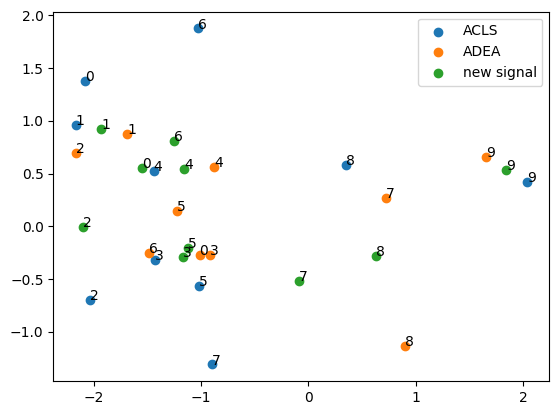

In [122]:
# interpolate between two signales
# take the first signal
print(f"latent_signal_np_array shape : {signals_latent.shape}")
signals_latent = signals_latent.reshape((number_of_stocks, number_of_sub_series, latent_dim))

signal_1_index,signal_1_name = 8, stock_symbols[8]

signal_2_index ,signal_2_name = 9, stock_symbols[9]
signal_1 = signals_latent[signal_1_index]
signal_2 = signals_latent[signal_2_index]

# define the number of points to interpolate
number_of_points = signal_1.shape[0]
print(f"number_of_points : {number_of_points}")
print(f"signal_1 shape : {signal_1.shape}")
print(f"signal_2 shape : {signal_2.shape}")
new_signal = np.zeros((number_of_points,latent_dim))

for i in range(number_of_points):


    new_signal[i] = (signal_1[i] + (signal_2[i]) ) / 2

# apply PCA to the new signal
#pca = PCA(n_components=2)
#
# plot the latent space with the 3 signals in different colors
#latent_space_new_signal = pca.fit_transform(new_signal)
latent_space_new_signal = new_signal
plt.scatter(signal_1[:,0],signal_1[:,1],label=signal_1_name)
plt.scatter(signal_2[:,0],signal_2[:,1],label=signal_2_name)
plt.scatter(latent_space_new_signal[:,0],latent_space_new_signal[:,1],label='new signal')
for i in range(number_of_points):
    plt.annotate(str(i), (signal_1[i, 0], signal_1[i, 1]))
    plt.annotate(str(i), (signal_2[i, 0], signal_2[i, 1]))
    plt.annotate(str(i), (latent_space_new_signal[i, 0], latent_space_new_signal[i, 1]))
plt.legend()
plt.show()

new signal shape : torch.Size([10, 32])
new signal decoded shape : (10, 100)
stocks_array_flatten shape : (97, 1000, 1)


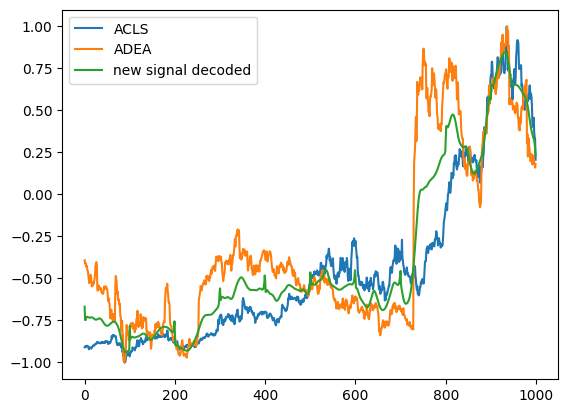

In [123]:
# decode the new signal
new_signal = torch.from_numpy(new_signal).float().to(device)
new_signal = new_signal.squeeze()
print(f"new signal shape : {new_signal.shape}")
with torch.no_grad():
    new_signal_decoded = model.decoder(new_signal)
    new_signal_decoded = nn.Tanh()(new_signal_decoded)
    new_signal_decoded = new_signal_decoded.squeeze().cpu().detach().numpy()
print(f"new signal decoded shape : {new_signal_decoded.shape}")
new_signal_decoded = new_signal_decoded.reshape((number_of_sub_series*sub_series_length,1))

stocks_array_flatten = stocks_np_array.reshape((number_of_stocks,number_of_sub_series*sub_series_length,1))
print(f"stocks_array_flatten shape : {stocks_array_flatten.shape}")
# plot the new signal decoded, the first signal and the second signal
plt.plot(stocks_array_flatten[signal_1_index],label=signal_1_name)
plt.plot(stocks_array_flatten[signal_2_index],label=signal_2_name)
plt.plot(new_signal_decoded,label='new signal decoded')
plt.legend()
plt.show()
